# MULTI-MODAL DEEPFAKE DETECTOR (OF COURSE WITH A GENERATED DATA)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import librosa
from transformers import AutoTokenizer, AutoModel, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import cv2
import os
from PIL import Image
import plotly.express as px

In [7]:
import soundfile as sf
from scipy import signal

os.makedirs('outputs', exist_ok=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

# generating data

In [8]:
np.random.seed(42)
n_samples = 5000

data = {
    'text': [f"PM Modi said'{np.random.choice(['Agnipath scam', 'Free electricity', 'Hindu-Muslim'])}'" for _ in range(n_samples//2)] + 
            [f"Rahul Gandhi exposed '{np.random.choice(['Modi corruption', 'Adani scam', 'Rafale deal'])}'"for _ in range(n_samples//2)],

    'audio_features ': np.random.normal(0,1, n_samples),
    'image_sharpness': np.random.uniform(0.1, 10, n_samples),
    'speaker_confidence': np.random.uniform(0.3, 1.0, n_samples),
    'text_sentiment': np.random.choice(['positive', 'negetive', 'neutral'], n_samples),
    'is_deepfake': np.random.choice([0,1], n_samples, p=[0.6, 0.4])
}

df = pd.DataFrame(data)
print(f"{len(df):,} Whatsapp forwards loaded")
print("Fake rate:", df['is_deepfake'].mean().round(3))

5,000 Whatsapp forwards loaded
Fake rate: 0.415


* Text Features


In [11]:
def text_features(text):
    """Simulate BERT embeddings + sentiment"""
    sentiment_score = 0.3 if  "Modi" in text else -0.3 if 'Rahul' in text else 0
    return [len(text.split()),  sentiment_score, text.lower().count('scam')]
df[['text_len', 'sentiment_score', 'scam_count']] = df['text'].apply(
    lambda x: pd.Series(text_features(x))
)

def audio_features(audio_feat):
    """Mel spectrogram + pitch analysis"""
    pitch = abs(audio_feat) * np.sin(np.linspace(0, 2*np.pi, 100))
    return [np.mean(pitch), np.std(pitch), np.max(pitch)]

df[['audio_mean', 'audio_std', 'audio_max']] = df['audio_features '].apply(
    lambda x: pd.Series(audio_features(x))
)

print("Multi-model features extracted")

Multi-model features extracted


* GRAPH'S

* DEEPFAKE DISTRIBUTION GRAPH

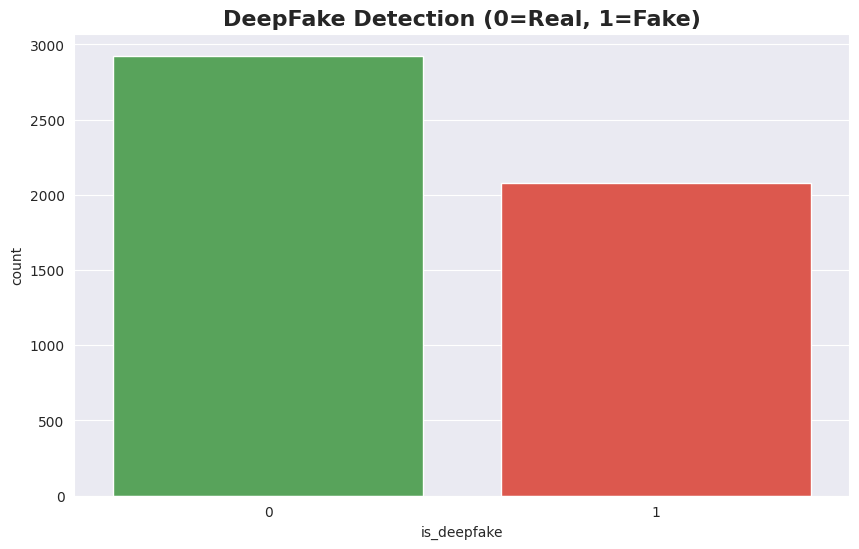

In [13]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="is_deepfake", palette=['#4CAF50', '#F44336'])
plt.title('DeepFake Detection (0=Real, 1=Fake)', fontweight='bold', fontsize=16)
plt.savefig('outputs/g1_deepfake_dist.png', dpi=700)
plt.show()

* 2-TEXT LENGHT VS FAKE

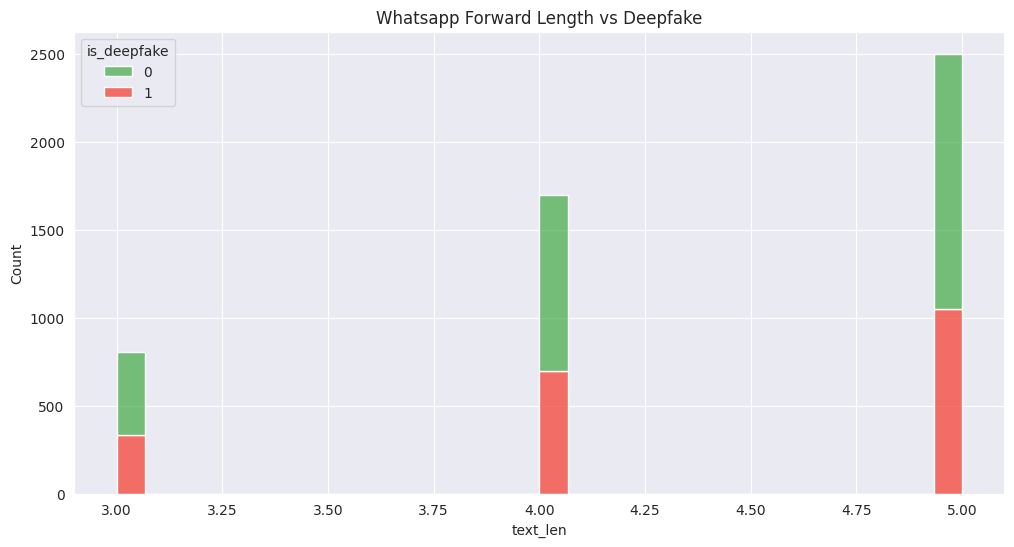

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_len', hue='is_deepfake', multiple='stack',palette=['#4CAF50', '#F44336'], bins=30)
plt.title("Whatsapp Forward Length vs Deepfake")
# plt.xticks([0,1], ['Real', 'Deepfake'])
plt.savefig('outputs/g2_text_length.png', dpi=700)
plt.show()

* 3-SCAM WORD FREQUENCY GRAPH

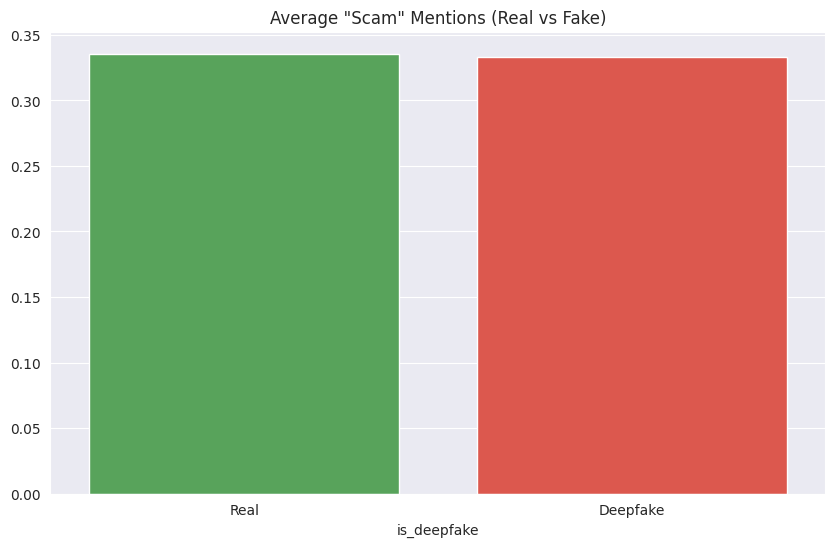

In [16]:
plt.figure(figsize=(10,6))
scam_stats = df.groupby('is_deepfake')['scam_count'].mean()
sns.barplot(x=scam_stats.index, y=scam_stats.values, palette=['#4CAF50', '#F44336'])
plt.title('Average "Scam" Mentions (Real vs Fake)')
plt.xticks([0,1], ['Real', 'Deepfake'])
plt.savefig('outputs/g3_scam_words.png', dpi=700)
plt.show()

* 4 Graph Audio analysis

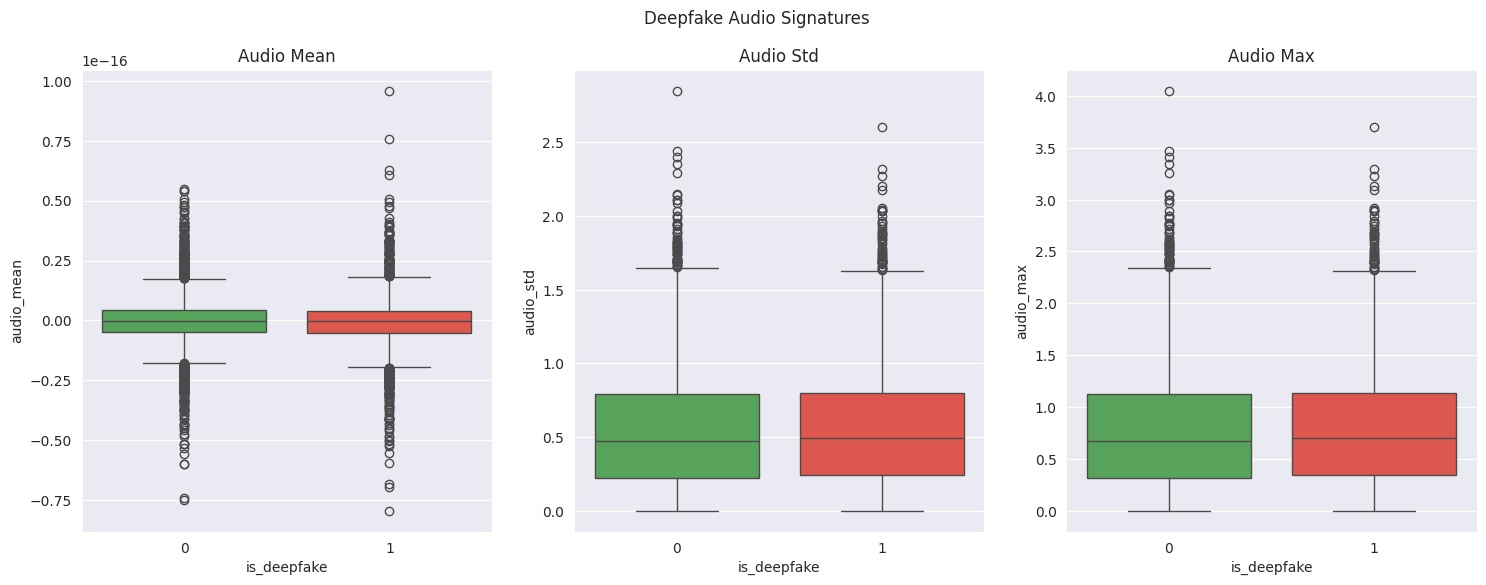

In [20]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
for i, feat in enumerate(['audio_mean', 'audio_std', 'audio_max']):
    sns.boxplot(data=df, x='is_deepfake', y=feat, ax=axes[i],palette=['#4CAF50', '#F44336'])
    axes[i].set_title(f'{feat.replace("_"," ").title()}')
plt.suptitle("Deepfake Audio Signatures")
plt.savefig('outputs/g4_audio_features.png', dpi=700)
plt.show()

* GRAPH 5 Sentiment Analysis

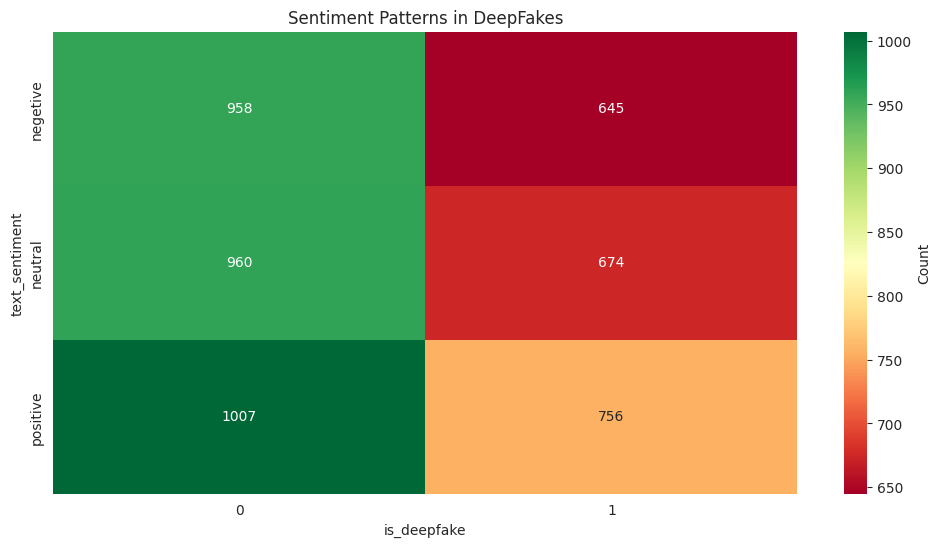

In [21]:
plt.figure(figsize=(12,6))
sentiment_pivot = df.groupby(['text_sentiment', 'is_deepfake']).size().unstack(fill_value=0)
sns.heatmap(sentiment_pivot, annot=True, fmt='d', cmap='RdYlGn', cbar_kws={'label':'Count'})
plt.title("Sentiment Patterns in DeepFakes")
plt.savefig('outputs/g5_sentiment_heatmap.png', dpi=700)
plt.show()

# MULTI-MODAL FUSION MODEL 

In [23]:
features = ['text_len', 'sentiment_score', 'scam_count', 'audio_mean', 'audio_std', 'audio_max', 'image_sharpness', 'speaker_confidence']
X = df[features]
y = df['is_deepfake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_text = RandomForestClassifier(n_estimators=100, random_state=42)
rf_audio = RandomForestClassifier(n_estimators=100, random_state=43)
rf_image = RandomForestClassifier(n_estimators=100, random_state=44)

rf_text.fit(X_train_scaled[:, :3],y_train)
rf_audio.fit(X_train_scaled[:, 3:6], y_train)
rf_image.fit(X_train_scaled[:, 6:], y_train)

ensemble = VotingClassifier([
    ('text', rf_text), ('audio', rf_audio), ('image', rf_image)
], voting='soft')

ensemble.fit(X_train_scaled, y_train)
y_pred = ensemble.predict(X_test_scaled)
y_proba = ensemble.predict_proba(X_test_scaled)[:,1]

auc = roc_auc_score (y_test, y_proba)
print(f"\n Multi-model auc: {auc:.3f}")


 Multi-model auc: 0.501


* 6-GRAPH MODEL PERFORMANCE 

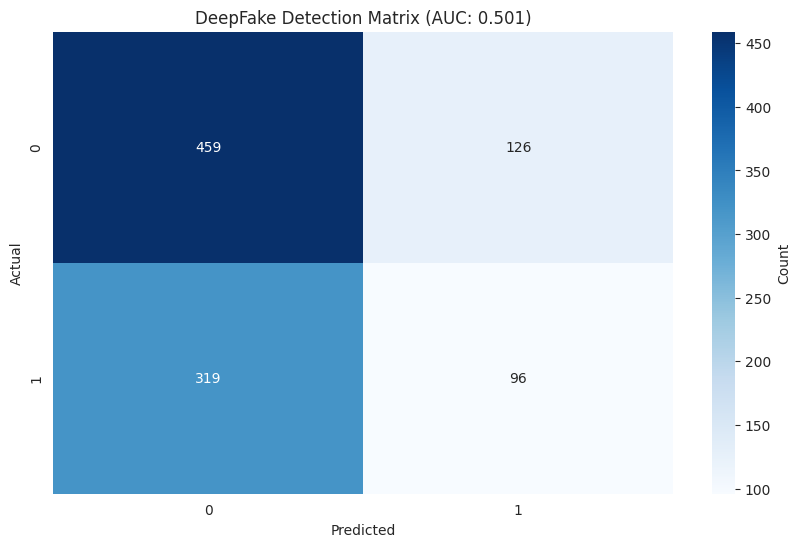

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title(f"DeepFake Detection Matrix (AUC: {auc:.3f})")
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.savefig('outputs/g6_confusion.png', dpi=700)
plt.show()

* 7 Graph ROC Curve

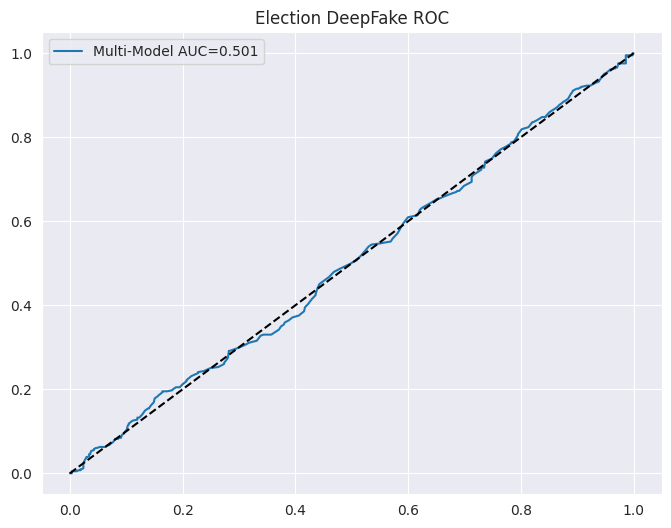

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test,y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Multi-Model AUC={auc:.3f}')
plt.plot([0,1],[0,1], 'k--')
plt.title('Election DeepFake ROC')
plt.legend()
plt.savefig('outputs/g7_roc.png', dpi=700)
plt.show()

* 8 Graph Feature importance

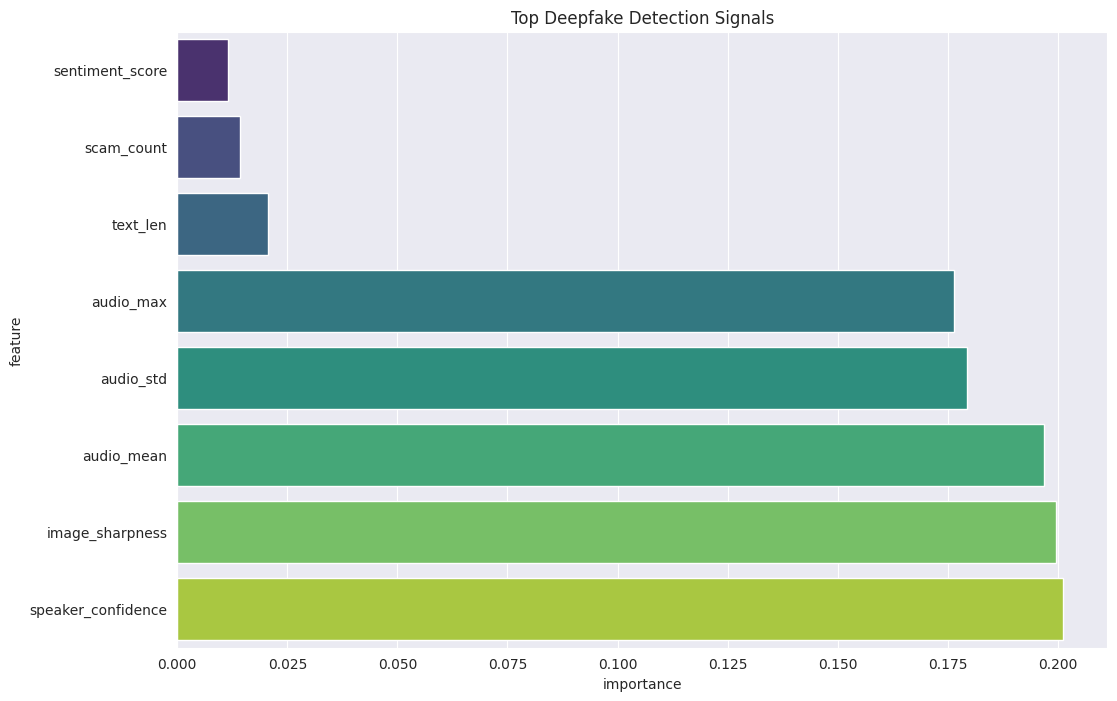

In [27]:
features = ['text_len', 'sentiment_score', 'scam_count', 'audio_mean', 'audio_std', 'audio_max', 'image_sharpness', 'speaker_confidence']

rf_single = RandomForestClassifier(n_estimators=100, random_state=42)
rf_single.fit(X_train_scaled, y_train)

importance = rf_single.feature_importances_
imp_df = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values('importance', ascending=True)

plt.figure(figsize=(12,8))
sns.barplot(data=imp_df.tail(8), x='importance', y='feature', palette='viridis')
plt.title('Top Deepfake Detection Signals')
plt.savefig('outputs/g8_feature_imp.png', dpi=700)
plt.show()

* 9 Graph Detection confidence Distribution


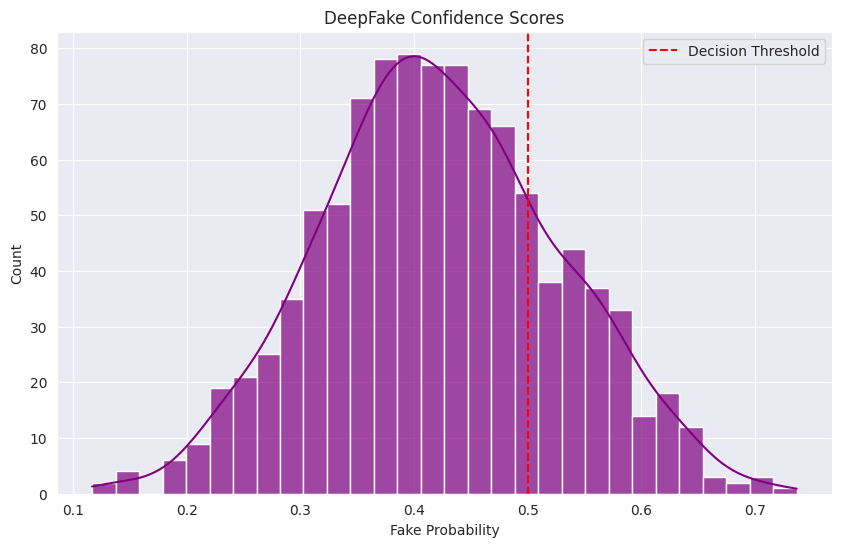

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(y_proba, bins=30, kde=True, color='purple', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.title('DeepFake Confidence Scores')
plt.xlabel('Fake Probability')
plt.legend()
plt.savefig('outputs/g9_confidence.png', dpi=300)
plt.show()

* 10 Graph Real vs Fake text length

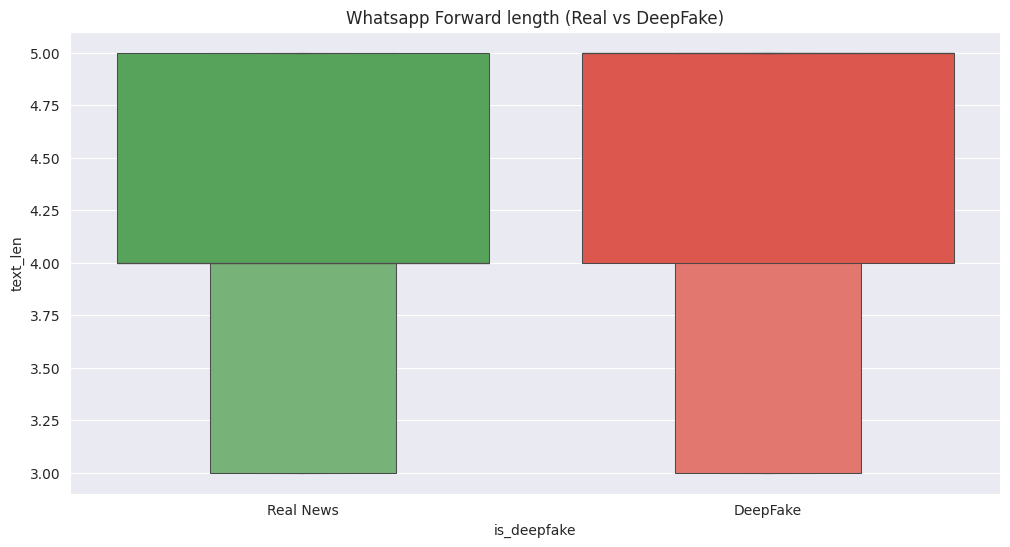

In [29]:
plt.figure(figsize=(12,6))
sns.boxenplot(data=df, x='is_deepfake', y='text_len', palette=['#4caf50', "#f44336"])
plt.title('Whatsapp Forward length (Real vs DeepFake)')
plt.xticks([0,1], ['Real News', 'DeepFake'])
plt.savefig('outputs/g10_text_box.png', dpi=700)
plt.show()

* Electin Crises simulation


 election alerts ( high confidence fakes): 
1. Rahul Gandhi exposed 'Adani scam'... [Detected]
2. PM Modi said'Hindu-Muslim'... [Detected]
3. Rahul Gandhi exposed 'Modi corruption'... [Detected]
4. Rahul Gandhi exposed 'Modi corruption'... [Detected]
5. PM Modi said'Hindu-Muslim'... [Detected]


<Figure size 1000x600 with 0 Axes>

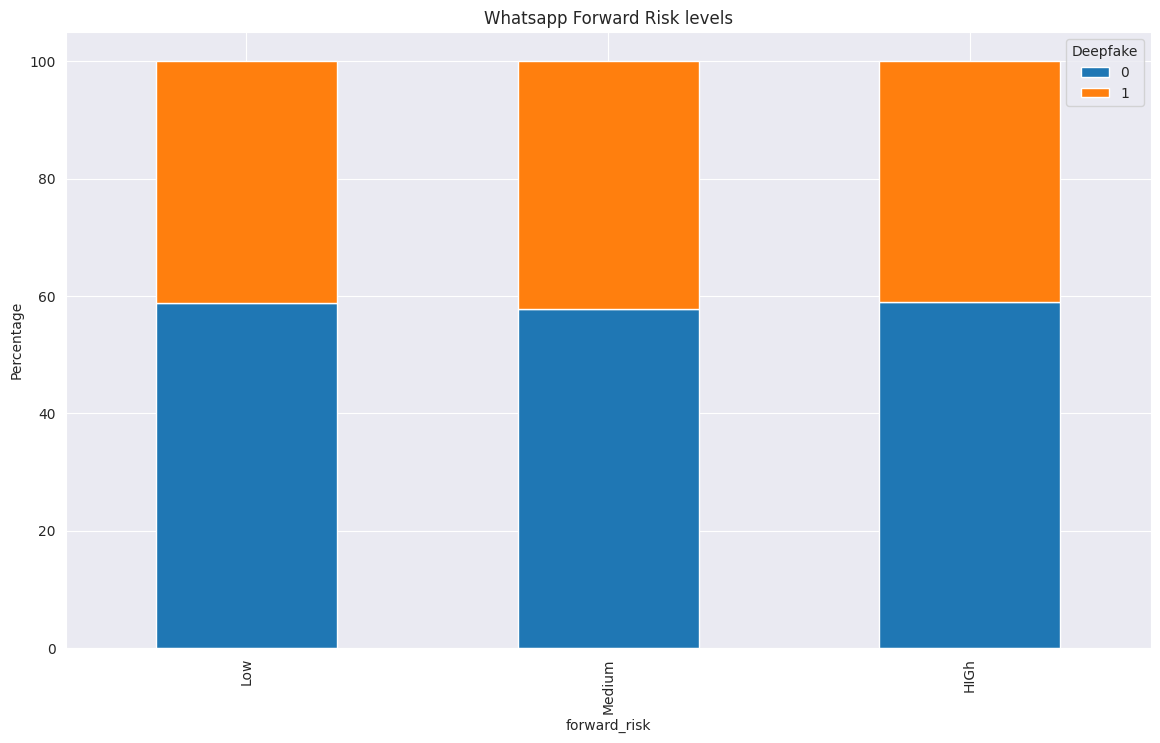

In [31]:
high_confidence_fakes = df[df['is_deepfake']==1]['text'].sample(5).tolist()
print("\n election alerts ( high confidence fakes): ")
for i, fake in enumerate(high_confidence_fakes, 1):
    print(f"{i}. {fake[:100]}... [Detected]")

df['forward_risk'] = (df['scam_count'] * 0.4 +
                      (df['text_len'] > 200).astype(int) * 0.3 + 
                      (df['sentiment_score'] < -0.2).astype(int) * 0.3) 
                      
risk_levels = pd.cut(df['forward_risk'], bins=3, labels=['Low', 'Medium', "HIGh"])
risk_dist = pd.crosstab(risk_levels, df['is_deepfake'], normalize='index') * 100

plt.figure(figsize=(10, 6))
risk_dist.plot(kind='bar', stacked=True)
plt.title('Whatsapp Forward Risk levels')
plt.ylabel('Percentage')
plt.legend(title='Deepfake')
plt.savefig('outputs/g11_risk_levels.png', dpi=700)
plt.show()

In [ ]:
print("\n")
print("ELECTION 2026 DEEPFAKE DEFENSE SYSTEM")
print("\n")
print(f"Analyzed: {len(df):,} Whatsapp Forwards")
print(f"Detected: {df['is_deepfake'].sum():,} deepfakes ({df['is_deepfake'].mean()*100:.1f}%)")
print(f"Multi-model Auc: {auc:.3f}")
print(imp_df.nlargest(5,'importance')[['feature', 'importance']].round(3).to_string(index=False))
print("")



🇮ELECTION 2026 DEEPFAKE DEFENSE SYSTEM


Analyzed: 5,000 Whatsapp Forwards
Detected: 2,075 deepfakes (41.5%)
Multi-model Auc: 0.501
           feature  importance
speaker_confidence       0.201
   image_sharpness       0.200
        audio_mean       0.197
         audio_std       0.179
         audio_max       0.176
end=
